# 2D CNN End2End Segmentation Pipeline on Tensorflow-Keras using DataLoader

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [ ]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: A100-SXM4-40GB
GPU Capability: (8, 0)
Is GPU Initialized yet? True


# Connect to Google Drive

Copy-Paste the Authorization Code and Mount Google Drive to COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Mounted at /content/GDrive


Move to the Target Directory

In [ ]:
%cd '/content'

/content


Load file from a local drive

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Import Libraries

Import Built-in Libraries

In [ ]:
from __future__ import division
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import gc
import cv2
import h5py
import glob
import scipy
import random
import shutil
import pickle
import configparser
import numpy as np
import pandas as pd
import seaborn as sns
import PIL.Image
from tqdm import tqdm
import tensorflow as tf
from scipy import interp
import albumentations as A
from itertools import cycle
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, jaccard_score, classification_report, mean_squared_error
from IPython.display import Image, display
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
sns.set_theme(style="darkgrid")

Import Importent Documents

In [ ]:
!gdown --id 1zg4Zi02E4R1yfIV_LVaglMATsq0T7PNs  # 2D Segmentation Models
!gdown --id 1w8BtmVDIkSw6WSO-Ijkxi-eDtb3VEKrm  # Helper Functions
!gdown --id 1RskgZ2aQPSqXvV8YHM4WXfDVl4qTW3Y8  # Important Functions
!gdown --id 1SZBem1z3LhAy3jX22RXExYT1PHWc8tMG  # Custom Loss Functions
!gdown --id 11prhvqfn8Fs7qH421tMYS4yqTLojkQrl  # Train.py
!gdown --id 106D-2WtDzZnWFSWDlLcaltG4BPaOTDNL  # Test.py
!gdown --id 14Iv50kaYUR179wL9EGGQy2TBKPkbSVrd  # TF_Losses
!gdown --id 1yGXCY5odazVLcOFimOoxuw8XMtogniQ_  # TF_Optimizers
!gdown --id 15ex-3JW_xYkw47bQni-Z2v-LabxISQDk  # TF_Metrics

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zg4Zi02E4R1yfIV_LVaglMATsq0T7PNs
To: /content/TF_2D_Segmentation_Models_with_Pretrained_Encoders.py
100% 754k/754k [00:00<00:00, 135MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w8BtmVDIkSw6WSO-Ijkxi-eDtb3VEKrm
To: /content/Helper_Functions.py
100% 46.0k/46.0k [00:00<00:00, 58.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  c

List Files and Folders in the Directory

In [ ]:
!ls

Custom_Loss_Functions.py  TF_2D_Segmentation_Models_with_Pretrained_Encoders.py
GDrive			  TF_Losses.py
Helper_Functions.py	  TF_Metrics.py
Important_Functions.py	  TF_Optimizers.py
sample_data		  Train.py
Test.py


# Main

## Import and Preprocess Data

General Instructions:

*   If your Data is in a ZIP/RAR/TAR File, start from Step 1. If no preprocessing is required, skip all steps and directly go for model building.
*   Step 1 does not require "Data Configurations".
*   If your data is raw or requires some preprocessing before fold creation, move to Step 2.
*   If you require to create folds, go to Step 3, skip otherwise.
*   If you require to Augment Images, mainly in the Training Set, follow Step 4.
*   Visualize any image from any fold from the Train/Test/Validation set.







### Step 1: Import and UnZip/UnRaR/UnTar Files based on the Name and File-type

In [ ]:
!gdown --id 10EDoN5ilUExZTeutaR24s-gc_9vaGUH5 # Import Data

UnZIP for ZIP Files

In [ ]:
!jar xvf Data.zip

UnRAR for RAR Files

In [ ]:
# !unrar x "input_file_name.rar" "/content/"

UnTAR for TAR Files

In [ ]:
# !tar -xvf "input_file_name.tar" -C "/content/"  #[run this cell to extract tar files]
# !tar -xzvf "input_file_name.tar.gz" -C "/content/"  #[run this cell to extract tar.gz files]
# !tar -xjvf "input_file_name.tar.bz2" -C "/content/"  #[run this cell to extract tar.bz2 files]

### Step 2: Preprocess Raw Data

If any "Module not Found' error, Upgrade 'albumentations' library to the latest version and restart runtime  
[Augmentation List from 'albumentations' GitHub](https://github.com/albumentations-team/albumentations#benchmarking-results)

In [ ]:
# !pip install albumentations --upgrade

Mention the Data Path for Raw Data and provide with a list of processing or augmentation steps, a sample is provided

In [ ]:
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE

# ADD NEW SECTION AND SETTINGS
config_file["DATA"]={
        "raw_data_path": 'Data/Test',  # Directory containing Raw Data
        }

# SAVE THE SETTINGS TO THE FILE
with open("Train Configurations.ini","w") as file_object:
    config_file.write(file_object)

In [ ]:
# PRINT FILE CONTENT
read_file = open("Train Configurations.ini", "r")
content = read_file.read()
print("Content of the config file are:\n")
print(content)
read_file.flush()
read_file.close()

In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
raw_data_path = config_file["DATA"]["raw_data_path"]  # EXTRACT VALUE

'List of Processes to be applied per image, vary it according to the requirements'
process_list = [A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
                ]

In [ ]:
def preprocess_rawdata(raw_data_path, process_list):
    num_folds = len(os.listdir(raw_data_path))
    for i in range(1, num_folds + 1):
        print(f'\nCurrently Processing Fold {i}')
        # List containing all images of a certain class in a certain fold
        Image_List = sorted(os.listdir(f'{raw_data_path}/Fold_{i}/Images/'))
        transform = A.Compose(process_list)
        for ii in range(0, (len(Image_List))):
            current_image = Image_List[ii]
            current_image = current_image[0:-4]
            # Read an image with OpenCV and convert it to the RGB colorspace
            org_image = cv2.imread(f'{raw_data_path}/Fold_{i}/Images/{Image_List[ii]}')  # Read Original Image
            img_nparray = np.asarray(org_image)
            if img_nparray.shape[2] > 3:
                org_image = org_image[:,:,:3]  # Remove Alpha (4th) Channel from the Image
            org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB Colorspace
            transformed_GT = transform(image=org_image)  # Augment Image and Corresponding Mask
            transformed_image = transformed_GT['image']
            cv2.imwrite(f'{raw_data_path}/Fold_{i}/Images/{current_image}.png', transformed_image, [int(cv2.IMWRITE_PNG_COMPRESSION),0])
            print(f'Image Number: {ii+1}')

In [ ]:
# from Helper_Functions import preprocess_rawdata
preprocess_rawdata(raw_data_path, process_list)

### Step 3: Create Folds from Raw Data

Create 'n' Folds from the Raw Dataset, this code only creates random stratification

In [ ]:
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE

# ADD NEW SECTION AND SETTINGS
config_file["DATA"]={
        "raw_data_path": 'Data/Test',  # Raw Data Directory, change the name accordingly
        "num_folds": 5,  # Number of Folds required
        "train_portion": 0.8,  # % of Data to be put in the training set, rest in the test set
        "val_portion": 0.2  # % of Train Data to be used for validation; optional parameter
        }

# SAVE THE SETTINGS TO THE FILE
with open("Train Configurations.ini","w") as file_object:
    config_file.write(file_object)

In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
raw_data_path = config_file["DATA"]["raw_data_path"]  # Raw Data Directory, change the name accordingly
num_folds = config_file["DATA"]["num_folds"]  # Number of Folds required
train_portion = config_file["DATA"]["train_portion"]  # % of Data to be put in the training set, rest in the test set
val_portion = config_file["DATA"]["val_portion"]  # % of Train Data to be used for validation; optional parameter

In [ ]:
create_folds(raw_data_path, num_folds, train_portion, validation_portion=val_portion)

### Step 4: Augment Data

If any "Module not Found' error or ValueError occurs, upgrade 'albumentations' library to the latest version and restart runtime

In [ ]:
!pip install albumentations --upgrade

[Augmentation List from 'albumentations' GitHub](https://github.com/albumentations-team/albumentations#benchmarking-results)

In [ ]:
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE

# ADD NEW SECTION AND SETTINGS
config_file["DATA"]={
        "raw_data_path": 'Data/Train',  # Directory containing Raw Data
        "augment_data_path": 'Data/Train',  # Directory for the Images to be Augmented
        "augmentation_num": 5  # Number of Augmentations per image
        }

# SAVE THE SETTINGS TO THE FILE
with open("Train Configurations.ini","w") as file_object:
    config_file.write(file_object)

['Train Configurations.ini']

In [ ]:
'Configurations'
config_file = configparser.ConfigParser()  # CREATE OBJECT
config_file.read("Train Configurations.ini")  # READ THE CONFIG FILE
augment_data_path = config_file["DATA"]["augment_data_path"]  # Augmentation is normally done on the Train Data but Test and Validation sets can be processed as well (e.g., resize) by changing the directory
augmentation_num = int(config_file["DATA"]["augmentation_num"])  # Number of Augmentations per Image

'List of Augmentations to be applied per image, vary it according to the requirements'
augmentation_list = [A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
                     A.Rotate(limit=(-90,90), interpolation=1, border_mode=1, p=1.0),
                     A.VerticalFlip(p=0.5),
                     A.HorizontalFlip(p=0.5),
                ]

'Configurations'

['Train Configurations.ini']

'List of Augmentations to be applied per image, vary it according to the requirements'

Augment Images

In [ ]:
def augment_segmentation_data(data_path, augmentation_list, augmentation_num):
    num_folds = len(os.listdir(data_path))+1
    # Declare an Augmentation Pipeline
    for i in range(5, 6):
        print(f'\nCurrently Processing Fold {i}')
        # List containing all images of a certain class in a certain fold
        Image_List = sorted(os.listdir(f'{data_path}/Fold_{i}/Images/'))
        Mask_List = sorted(os.listdir(f'{data_path}/Fold_{i}/Masks/'))
        for ii in range(0, (len(Mask_List))):
            current_image = Image_List[ii]
            current_image = current_image[0:-4]
            current_mask = Mask_List[ii]
            current_mask = current_mask[0:-4]
            # Read an image with OpenCV and convert it to the RGB colorspace
            org_image = cv2.imread(f'{data_path}/Fold_{i}/Images/{Image_List[ii]}')  # Read Original Image
            corresponding_mask = cv2.imread(f'{data_path}/Fold_{i}/Masks/{Mask_List[ii]}')  # Read Original Image
            img_nparray = np.asarray(org_image)
            if img_nparray.shape[2] > 3:
                org_image = org_image[:,:,:3]  # Remove Alpha (4th) Channel from the Image
            org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB Colorspace
            msk_nparray = np.asarray(corresponding_mask)
            if msk_nparray.shape[2] > 1:
                corresponding_mask = corresponding_mask[:,:,0]  # Convert masks to Grayscale images from RGB
            for iv in range(1, augmentation_num + 1):
                transform = A.Compose(augmentation_list)
                transformed_GT = transform(image=org_image, mask=corresponding_mask)  # Augment Image and Corresponding Mask
                transformed_image = transformed_GT['image']
                transformed_mask = transformed_GT['mask']
                cv2.imwrite(f'{data_path}/Fold_{i}/Images/{current_image}_Augmented_{iv}.png', transformed_image, [int(cv2.IMWRITE_PNG_COMPRESSION),0])
                cv2.imwrite(f'{data_path}/Fold_{i}/Masks/{current_mask}_Augmented_{iv}.png', transformed_mask, [int(cv2.IMWRITE_PNG_COMPRESSION),0])
            print(f'Image Number: {ii+1}')

In [ ]:
# from Helper_Functions import augment_segmentation_data
augment_segmentation_data(augment_data_path, augmentation_list, augmentation_num)

### Check and Visualize Images

In [ ]:
# Open the image form working directory
image_path = '/content/Data/Train/Fold_1/Images/ (1)_Augmented_1.png'
mask_path = '/content/Data/Train/Fold_1/Masks/ (1)_Augmented_1.png'
# load and show an image with Pillow
image = PIL.Image.open(image_path)
print('Sample Image')
print(image.mode)
# convert image to numpy array
data = np.asarray(image)
print(type(data))  # Type of the Image (e.g., RGB, BGR or RGBA)
# summarize shape
print(data.shape)  # Shape of the Images
print(np.max(data[:,:]))  # Compute Pixel information
#
print('Corresponding Mask')
# load and show an image with Pillow
mask = PIL.Image.open(mask_path)
print(mask.mode)
# convert image to numpy array
data = np.asarray(mask)
print(type(data))  # Type of the Image (e.g., RGB, BGR or RGBA)
# summarize shape
print(data.shape)  # Shape of the Images
print(np.max(data[:,:]))  # Compute Pixel information

Sample Image
RGB
<class 'numpy.ndarray'>
(256, 256, 3)
255
Corresponding Mask
L
<class 'numpy.ndarray'>
(256, 256)
255


Plot Images

<Figure size 1350x720 with 0 Axes>

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd0a348f1d0>,
 <matplotlib.image.AxesImage at 0x7fd0a2fdbf50>)

Text(0.5, 1.0, 'Kidney US Image')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd0a2fb2990>,
 <matplotlib.image.AxesImage at 0x7fd0a1793a10>)

Text(0.5, 1.0, 'Corresponding GT Mask')

(-0.5, 255.5, 255.5, -0.5)

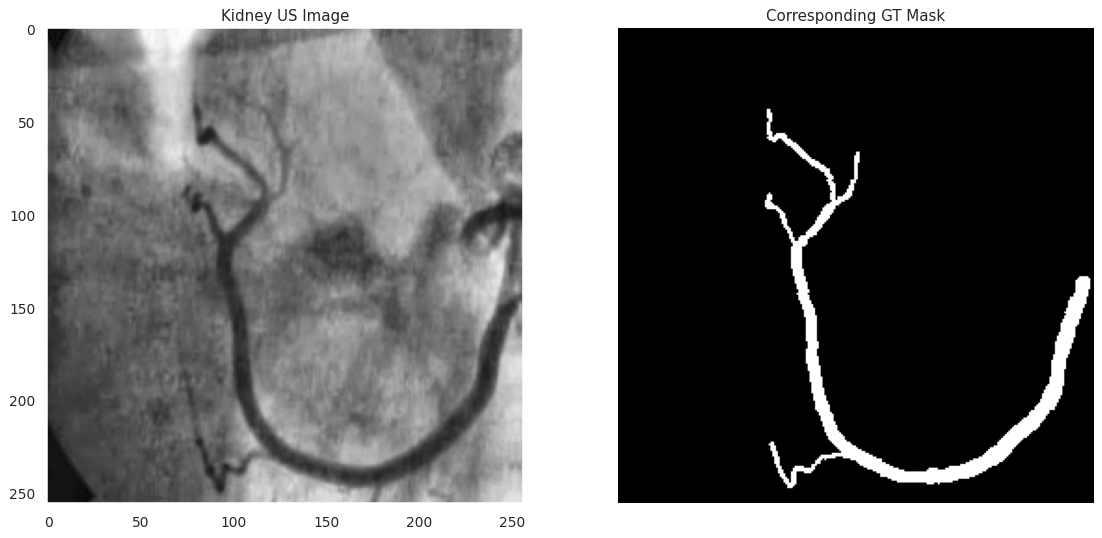

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=90)

image1 = plt.imread(image_path, cv2.IMREAD_UNCHANGED)
image2 = plt.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.subplot(1, 2, 1), plt.imshow(image1, 'gray')
plt.grid(False)
plt.title(f"Kidney US Image")
plt.subplot(1, 2, 2), plt.imshow(image2, 'gray')
plt.title(f"Corresponding GT Mask")
plt.axis('off')
plt.show() # To show figure

## Train

### Free RAM

In [ ]:
# Garbage Collector
Segmentation_Model = None # Delect any existing Model from the Memory to avoid Reuse
gc.collect()

22

### Set Train Configurations

**Available 2D-Segmentation Models (Decoders):**
* **UNet**
* **Ensembled UNet** (UNetE)
* **UNet+** (UNetP)
* **UNet++** (UNetPP)
* **UNet3+** (UNet3P)
* **MultiResUNet**

**Supported ImageNet Trained Encoders:**
* **ResNet:** ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
* **VGG:** VGG16, VGG19
* **DenseNet:** DenseNet121, DenseNet169, DenseNet201
* **MobileNet:** MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
* **Inception:** InceptionV3, InceptionResNetV2
* **EfficientNetV1:** EfficientNetB[0-7]
* **EfficientNetV2:** EfficientNetV2B[0-3], EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
* **CheXNet**

**Supported Loss Functions:** Check "TF_Losses.py" file  
**Supported Optimizers:** Adam, Adadelta, Adagrad, Adamax, FTRL, Nadam, RMSProp, SGD  
**Supported Metrics:** Check "TF_Metrics.py" file  

In [ ]:
# CREATE OBJECT
config_file = configparser.ConfigParser()

# ADD NEW SECTION AND SETTINGS
config_file["TRAIN"] = {
        # General Configurations
        "train_dir": "Data/Train/",  # Train Image Directory
        "val_dir": "Data/Val/",  # Validation Image Directory
        "data_loading_mode": "TF_DataLoader",  # TF_DataLoader: Use TensorFlow DataLoader module to load data | Legacy: Load all train and validation data
        "independent_val_set": True,  # True: Independent Validation Set | False: Validation Set randomly splitted from the Training Set
        "validation_portion": 0.2,  # 0 to 1 [Default: 0; when validation set is independent, otherwise created randomly while training based on "validation_portion"]
        "imlength": 512,  # Length or Height of the Image | Image Size: [imlength, imwidth]
        "imwidth": 512,  # Width of the Image
        "image_color_mode": "rgb",  # Color Mode of the images [rgb, rgba (rgb with transparent alpha channel), grayscale (black and white single channel image)]
        "mask_color_mode": "grayscale",  # Color Mode of the images [rgb, rgba (rgb with transparent alpha channel), grayscale (black and white single channel image)]
        "num_channel": 3,  # Number of Input Channels in the Model [rgb:3, rgba:4, grayscale:1]
        "normalizing_factor": 255.0,  # 255.0 for images with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        # Model Configurations
        "encoder_mode": "from_scratch",  # Transfer Learning: "pretrained_encoder" | Train from scratch: "from_scratch"
        # Encoder Configurations: Configurations specific to the "pretrained_encoder" mode [None if encoder_mode: "from_scratch"]
        "encoder_name": "InceptionV3", # Select an Encoder from a pool of ImageNet trained Models available from TensorFlow, default: ResNet50
        "encoder_trainable": False,  # Fine Tuning ON/OFF [True/False] | Start with OFF, Fine Tune later in the 2nd stage, which is optional
        # Decoder Configurations: General Configurations for both encoder modes
        "decoder_name": "AHNet",  # Select a Model from the list to train from scratch, UNet is kept as default
        "model_width": 16,  # Width of the Initial Layer, subsequent layers start from here
        "model_depth": 5,  # Depth or Number of Layers in the Model [For the "pretrained_encoder" mode: Maximum 5, Minimum 1]
        "D_S": 0,  # Turn on Deep Supervision [Default: 0]
        "A_E": 0,  # Turn on AutoEncoder Mode for Feature Extraction [Default: 0]
        "A_G": 0,  # Turn on for Guided Attention [Default: 0]
        "LSTM": 0,  # Turn on for LSTM [Default: 0]
        "num_dense_loop": 2,  # Number of Densely Connected Residual Blocks in the BottleNeck Layer [Default: 2]
        "problem_type": 'Regression',  # Problem Type: Classification (Multi-Output) or Regression (Single Output, can be multi-class)
        "output_nums": 1,  # Number of Outputs
        "class_number": 1,  # Number of Output Classes [e.g., here for Kidney Tumor segmentation, Class 1: Kidney | Class 2: Tumor]
        "is_transconv": True,  # True: Transposed Convolution | False: UpSampling in the Decoder layer
        "final_activation": "sigmoid",  # Activation Function for the Final Layer: "Linear", "Sigmoid", "Softmax", etc. depending on the problem type
        "feature_number": 1024,  # Number of Features to be Extracted [Only required for the AutoEncoder (A_E) Mode]
        "ds_type": "UNet",  # "UNet" or "UNetPP"; only required when Deep Supervision (D_S) is on
        "alpha": 1,  # Alpha parameter, required for MultiResUNet models [Default: 1]
        # Training Configurations
        "batch_size": 4,  # Batch Size of the Images being loaded for training
        "learning_rate": 0.0001,  # During Fine-Tuning the network, the Learning Rate should be very low (e.g., 1e-5), otherwise more (e.g., 1e-4, 1e-3)
        "start_fold": 5,  # Fold to Start Training, can be varied from 1 to the last fold
        "end_fold": 6,  # Fold to End Training, can be any value from the start_fold [Number of Folds + 1]
        "num_iter": 1,  # Number of Folds completed training
        "monitor_param": "val_mean_squared_error",  # Monitoring parameter during training
        "patience_amount": 20,  # Number of epochs to wait before training to stop
        "patience_mode": "min",  # patience mode: 'min', 'max' or 'auto'
        "num_epochs": 200,  # Number of epochs for training
        "loss_function_name": "BinaryCrossentropy", # Loss Functions
        "optimizer_function_name": "Adam",  # Optimization Algorithm
        "metric_list": "MeanSquaredError",  # Metric(s) being monitored
        "seed": 42  # SEED required for randomly split Validation set from the Training set, not used when "validation_portion"= 0.0
        }

# SAVE CONFIG FILE
with open(r"Train Configurations.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Train Configurations.ini' created")

Config file 'Train Configurations.ini' created


### Start Training

Major Flexible Training Loop Accross Folds

In [ ]:
!python Train.py

### Fine-Tune Model (Optional)

Update Training Configurations for the Fine-Tuning Mode

In [ ]:
config = configparser.ConfigParser()
config.read('Train Configurations.ini')
config.set('TRAIN', 'encoder_trainable', 'True')
config.set('TRAIN', 'learning_rate', '0.00005')
config.set('TRAIN', 'patience_amount', '10')
config.set('TRAIN', 'num_epochs', '100')

with open('Train Configurations.ini', 'w') as configfile:
    config.write(configfile)

Fine-Tune Model through Re-training
* Make sure a previously trained model is loaded
* Fine-tuning a previously trained model after unfreezing the previously frozen layers of the trained encoder should be done with a very low learning rate (e.g., 10X-20X lower than the original)

In [ ]:
!python Train.py

## Inference

Set Test Configurations

In [ ]:
import configparser

# CREATE OBJECT
config_file = configparser.ConfigParser()

# ADD NEW SECTION AND SETTINGS
config_file["TEST"] = {
        # General Configurations
        "test_dir": "Data/Test",
        "imheight": 512,  # Size of the Images being Trained, they will be resized in this shape: [imsize, imsize]
        "imwidth": 512,  # Size of the Images being Trained, they will be resized in this shape: [imsize, imsize]
        "color_mode": "rgb",  # Color Mode of the images
        "num_channel": 3,  # Number of Input Channels in the Model [rgb:3, rgba:4, grayscale:1]
        "num_class": 1,  # Number of Output Classes in the Task
        "labels": "",
        # Model Configurations
        "encoder_name": "Scratch", # Select an Encoder from a pool of ImageNet trained Models available from TensorFlow, default: Scratch
        "decoder_name": "AHNet",  # Select a Model from the list to train from scratch, ResNet50 is kept as default
        # Test Configurations
        "batch_size": 4,  # Batch Size of the Images bein loaded for training
        "normalizing_factor": 255.0,  # 255.0 for images with pixel values varying between 0 to 255. If it is between 0 to 1, change it to 1
        "start_fold": 5,  # Fold to Start Training, can be varied from 1 to the last fold
        "end_fold": 6,  # Fold to End Training, can be any value from the start_fold [Number of Folds + 1]
        "num_iter": 1,  # Number of Folds completed training
        "threshold": 0.5,  # SEED required for randomly split Validation set from the Training set, not used when "validation_portion"= 0.0
        "seed": 42  # SEED required for randomly split Validation set from the Training set, not used when "validation_portion"= 0.0
        }

# SAVE CONFIG FILE
with open(r"Test Configurations.ini", 'w') as configfileObj:
    config_file.write(configfileObj)
    configfileObj.flush()
    configfileObj.close()

print("Config file 'Test Configurations.ini' created")

Config file 'Test Configurations.ini' created


Test and Evaluate

In [ ]:
!python Test.py

In [ ]:
from Helper_Functions import dice
# Visualize
img_name = '1.2.392.200036.9116.6.23.10552866.2289.20220105085435698.1.756.png'
gt_msk_name = img_name
pred_msk_name = 'Predicted_' + img_name
img_dir = 'Data/Test/Fold_1/Images/' + gt_msk_name
gt_msk_dir = 'Data/Test/Fold_1/Masks/' + img_name
pred_msk_dir = 'Data/Test/Fold_1/Predictions/' + pred_msk_name
threshold = 0.5
#
img = PIL.Image.open(img_dir)
gt_msk = PIL.Image.open(gt_msk_dir)
pred_msk = PIL.Image.open(pred_msk_dir)

print(gt_msk.mode)
# convert image to numpy array
data = np.asarray(gt_msk)
print(type(data))  # Type of the Image (e.g., RGB, BGR or RGBA)
# summarize shape
print(data.shape)  # Shape of the Images
print(np.max(data))  # Compute Pixel information

fig,ax = plt.subplots(1,3,figsize=[30,10])
ax[0].imshow(img, cmap='gray')
ax[1].imshow(gt_msk, cmap='gray')
ax[2].imshow(pred_msk, cmap='gray')
ax[0].set_title(f"Input Image", fontdict={'fontsize': 16})
ax[1].set_title(f"Ground Truth Mask", fontdict={'fontsize': 16})
ax[2].set_title(f"Predicted Mask", fontdict={'fontsize': 16})
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
#
y_true = np.asarray(gt_msk)/255.0
y_pred = np.asarray(pred_msk)
y_true = np.where(y_true > threshold, 1, 0)
y_pred = np.where(y_pred > threshold, 1, 0)
y_true = np.asarray(y_true.ravel())
y_pred = np.asarray(y_pred.ravel())
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
F1Score = f1_score(y_true, y_pred, average='weighted')
JaccardScore = jaccard_score(y_true, y_pred, average='weighted')
DiceSimilarityScore = dice(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred, sample_weight=None, normalize=None)
FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
specificity = np.mean(TN/(TN+FP)) 
#
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall or Sensitivity: {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'F1-Score: {F1Score:.3f}')
print(f'IoU or Jaccard Score: {JaccardScore:.3f}')
print(f'Dice Similarity Score: {DiceSimilarityScore:.3f}')
print('Confusion Matrix: ')
print(conf_mat)

#### Get Pixel Array from Image Sets

##### Get Pixels only inside the Field of Vision (FoV) of the GT Masks

In [ ]:
# Predictions only inside the FOV by removing the black background
y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)  # Returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y-scores pixels: " +str(y_scores.shape[0]) + " | Including Background: " +str(pred_imgs.shape[0]*pred_imgs.shape[1]*pred_imgs.shape[2]))
print("y-true pixels: " +str(y_true.shape[0]) + " | Including Background: " +str(gtruth_masks.shape[0]*gtruth_masks.shape[1]*gtruth_masks.shape[2]))

Calculating results only inside the FOV:
y-scores pixels: 291562 | Including Background: 8454144
y-true pixels: 291562 | Including Background: 8454144


##### Get all Pixels

In [ ]:
# Get all Pixels
y_true = np.asarray(Y_Test.ravel())
y_scores = np.asarray(Predictions.ravel())
print("Calculating results for All Pixels:")
print("y-scores pixels: " + str(y_scores.shape[0]))
print("y-true pixels: " + str(y_true.shape[0]))

Calculating results for All Pixels:
y-scores pixels: 338437120
y-true pixels: 338437120


In [ ]:
threshold = 0.5
y_true = np.where(y_true > threshold, 1, 0)
y_pred = np.where(y_scores > threshold, 1, 0)

#### Visualize Pixel Density or Distribution

In [ ]:
df = pd.DataFrame(data = {'Ground Truth': y_true, 'Predictions': y_scores})
plt.figure(figsize=(15,10))
sns.set_style('whitegrid')
sns.kdeplot(data=df)
plt.title('KDE Plot for Ground Truth and Predictions', fontsize=20)
plt.xlabel('Magnitude', fontsize=15)
plt.ylabel('Density', fontsize=15)

Violin Plot

In [ ]:
plt.figure(figsize = (15,10))
df = pd.DataFrame(data = {'Ground Truth': y_true, 'Predictions': y_scores})
ax = sns.violinplot(data=df)
plt.title('Violin Plot for Ground Truth and Predictions', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

#### Visualize Outcome

Plot GT Image, Mask and Predicted Masks

In [ ]:
# Visualize
fig,ax = plt.subplots(20,4,figsize=[20,50])

for idx in range(20):
    offset = 20
    ax[idx,0].imshow(np.float32(np.squeeze((orig_imgs[idx+offset]))), cmap='gray')
    ax[idx,1].imshow(np.squeeze(gtruth_masks[idx+offset]), cmap='gray')
    ax[idx,2].imshow(np.squeeze(pred_imgs[idx+offset]), cmap='gray')
    img = np.float32(np.squeeze(pred_imgs[idx+offset]))
    ret, thresh = cv2.threshold(img,0.5,1,cv2.THRESH_BINARY)
    ax[idx,3].imshow(thresh, cmap='gray')
    ax[idx,0].set_title(f"Input Image {idx+offset}")
    ax[idx,1].set_title(f"Ground Truth Mask {idx+offset}")
    ax[idx,2].set_title(f"Predicted Mask {idx+offset}")
    ax[idx,3].set_title(f"Thresholded Predicted Mask {idx+offset}")
    ax[idx,0].axis("off")
    ax[idx,1].axis("off")
    ax[idx,2].axis("off")
    ax[idx,3].axis("off")

plt.savefig(path_experiment+f'Sample_Results_for_Test_Images_{offset}_to_{idx+offset}.png')

In [ ]:
# Visualize
fig,ax = plt.subplots(1,4,figsize=[30,10])

idx = 76
ax[0].imshow(np.float32(np.squeeze((orig_imgs[idx]))), cmap='gray')
ax[1].imshow(np.squeeze(gtruth_masks[idx]), cmap='gray')
ax[2].imshow(np.squeeze(pred_imgs[idx]), cmap='gray')
img = np.float32(np.squeeze(pred_imgs[idx]))
ret, thresh = cv2.threshold(img,0.4,1,cv2.THRESH_BINARY)
ax[3].imshow(thresh, cmap='gray')
ax[0].set_title(f"Input Image {idx}")
ax[1].set_title(f"Ground Truth Mask {idx}")
ax[2].set_title(f"Predicted Mask {idx}")
ax[3].set_title(f"Thresholded Predicted Mask {idx}")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")

## Copy Experiment Results from Virtual Machine or VM (Contents) to a Google Drive Folder

In [ ]:
!cp -av '/content/Results/' '/content/GDrive/MyDrive/Colab_Notebooks/Research/Kidney_AHN_Thesis_Task/'

In [ ]:
!cp -av '/content/Data/Test/Fold_5/Predictions/' '/content/GDrive/MyDrive/Colab_Notebooks/Research/Kidney_AHN_Thesis_Task/'

## Copy Documents from a Google Drive Folder to VM (Contents)

In [ ]:
!cp -av '/content/GDrive/MyDrive/Research/Kidney_AHN_Segmentation/Results' '/content'

## Remove non-empty Directory from Contents

In [ ]:
shutil.rmtree('/content/Data')

# Run Infinitely

In [ ]:
while True:
    pass